# Random Forest

In [242]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [243]:
df = pd.read_csv('data/df_clean.csv')

In [244]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41292 entries, 0 to 41291
Data columns (total 15 columns):
Unnamed: 0              41292 non-null int64
loan_amnt               41292 non-null float64
term_is_36              41292 non-null int64
int_rate                41292 non-null float64
grade                   41292 non-null object
sub_grade               41292 non-null object
emp_length              41292 non-null float64
annual_inc              41292 non-null float64
purpose                 41292 non-null object
addr_state              41292 non-null object
dti                     41292 non-null float64
inq_last_6mths          41292 non-null float64
open_acc                41292 non-null float64
pub_rec_bankruptcies    41292 non-null int64
default                 41292 non-null int64
dtypes: float64(7), int64(4), object(4)
memory usage: 4.7+ MB
None


## Upscaling of the minority class default = 1

Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

There are several heuristics for doing so, but the most common way is to simply resample with replacement.

First, we'll import the resampling module from Scikit-Learn:

In [245]:
from sklearn.utils import resample

Next, we'll create a new DataFrame with an up-sampled minority class. Here are the steps:

First, we'll separate observations from each class into different DataFrames.
Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.
Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [246]:
df.default.value_counts()

0    35006
1     6286
Name: default, dtype: int64

In [247]:
# Separate majority and minority classes
df_majority = df[df.default==0]
df_minority = df[df.default==1]

majority_size = df_majority.shape[0]

print(majority_size)

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=majority_size,    # to match majority class
                                 random_state=123) # reproducible results

df_minority_upsampled.columns
df_minority_upsampled.drop(columns='Unnamed: 0',inplace=True,axis=1)

35006


/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [248]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.default.value_counts()
df_upsampled.drop(columns='Unnamed: 0',inplace=True)

/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [249]:
df_upsampled.head()

,addr_state,annual_inc,default,dti,emp_length,grade,inq_last_6mths,int_rate,loan_amnt,open_acc,pub_rec_bankruptcies,purpose,sub_grade,term_is_36
0,AZ,24000.0,0,27.65,10.0,B,1.0,0.1065,5000.0,3.0,0,credit_card,B2,1
2,IL,12252.0,0,8.72,10.0,C,2.0,0.1596,2400.0,2.0,0,small_business,C5,1
3,CA,49200.0,0,20.00,10.0,C,1.0,0.1349,10000.0,10.0,0,other,C1,1
4,AZ,36000.0,0,11.20,3.0,A,3.0,0.0790,5000.0,9.0,0,wedding,A4,1
5,NC,47004.0,0,23.51,8.0,C,1.0,0.1596,7000.0,7.0,0,debt_consolidation,C5,0


In [250]:
df_upsampled.shape

(70012, 14)

## Scaling

In [251]:
df_upsampled.columns

Index(['addr_state', 'annual_inc', 'default', 'dti', 'emp_length', 'grade',
       'inq_last_6mths', 'int_rate', 'loan_amnt', 'open_acc',
       'pub_rec_bankruptcies', 'purpose', 'sub_grade', 'term_is_36'],
      dtype='object')

In [253]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler_min_max = MinMaxScaler()

scaling_list = ["dti", "int_rate", "loan_amnt","annual_inc"]
scaling_min_max = ["annual_inc"]

def logarithmize(value):
    #print(value)
    logvalue = np.log(value)
    return logvalue

df_upsampled[scaling_min_max] = df_upsampled[scaling_min_max].apply(lambda x: logarithmize(x))

df_upsampled[scaling_list] = scaler.fit_transform(df_upsampled[scaling_list])


<AxesSubplot:>

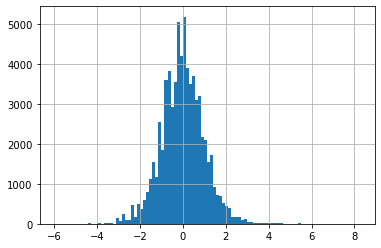

In [254]:
df_upsampled.annual_inc.hist(bins=100)

<AxesSubplot:>

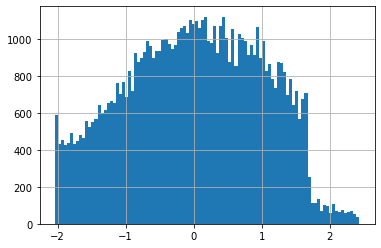

In [255]:
df_upsampled.dti.hist(bins=100)

<AxesSubplot:>

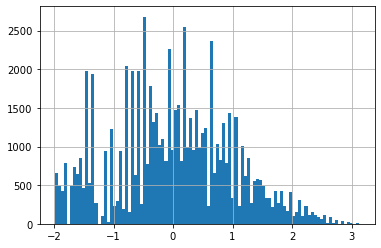

In [256]:
df_upsampled.int_rate.hist(bins=100)

<AxesSubplot:>

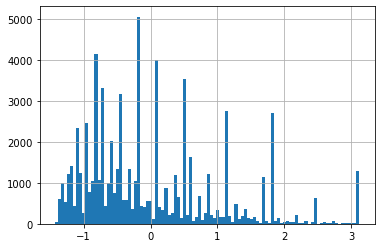

In [257]:
df_upsampled.loan_amnt.hist(bins=100)

## Create Dummies

In [258]:
cat_feats = ['grade','sub_grade','purpose','addr_state']

In [259]:
df = df_upsampled.copy()

In [260]:
df_final = pd.get_dummies(df, columns=cat_feats, drop_first=True)

In [261]:
df_final.head()

,annual_inc,default,dti,emp_length,inq_last_6mths,int_rate,loan_amnt,open_acc,pub_rec_bankruptcies,term_is_36,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,-1.490470,0,2.087959,10.0,1.0,-0.589269,-0.835995,3.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-2.673414,0,-0.738023,10.0,2.0,0.827247,-1.179065,2.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.227518,0,0.945922,10.0,1.0,0.168340,-0.176245,10.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-0.777104,0,-0.367794,3.0,3.0,-1.322869,-0.835995,9.0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,-0.307853,0,1.469915,8.0,1.0,0.827247,-0.572095,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [262]:
df_final.shape

(70012, 112)

## Train Test Split

In [263]:
from sklearn.model_selection import train_test_split

X = df_final.drop('default', axis=1)
y = df_final['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Decision Tree

In [264]:
from sklearn.tree import DecisionTreeClassifier

In [265]:
dtree = DecisionTreeClassifier()

In [266]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [267]:
predictions = dtree.predict(X_test)
train_predictions = dtree.predict(X_train)

In [268]:
from sklearn.metrics import classification_report, confusion_matrix

In [269]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     10501
           1       0.83      0.98      0.90     10503

    accuracy                           0.89     21004
   macro avg       0.91      0.89      0.89     21004
weighted avg       0.91      0.89      0.89     21004



In [270]:
print(confusion_matrix(y_test, predictions))

[[ 8424  2077]
 [  174 10329]]


In [271]:
print(classification_report(y_train, train_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24505
           1       1.00      1.00      1.00     24503

    accuracy                           1.00     49008
   macro avg       1.00      1.00      1.00     49008
weighted avg       1.00      1.00      1.00     49008



In [272]:
print(confusion_matrix(y_train, train_predictions))

[[24504     1]
 [    0 24503]]


In [273]:
from sklearn.model_selection import StratifiedKFold

def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),float)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y.values):
        print(len(train_indices),len(val_indices))
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
  
        model.fit(X=x_train,y=y_train)
        train_pred = np.append(train_pred, model.predict(x_val))
        test_pred =  np.append(test_pred,  model.predict(test))
    return test_pred.reshape(-1,1),train_pred

In [274]:
model = dtree
train = X_train
y = y_train
test = X_test
n_fold = 10

In [275]:
a, b = Stacking(model,train,y,test,n_fold)

/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


44107 4901
44107 4901
44107 4901
44107 4901
44107 4901
44107 4901
44107 4901
44107 4901
44108 4900
44108 4900


# Random Forest

In [276]:
from sklearn.ensemble import RandomForestClassifier

In [277]:
rnc = RandomForestClassifier()

In [278]:
rnc.fit(X_train, y_train)

RandomForestClassifier()

In [279]:
pred_train = rnc.predict(X_train)

In [280]:
pred_test = rnc.predict(X_test)

In [281]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24505
           1       1.00      1.00      1.00     24503

    accuracy                           1.00     49008
   macro avg       1.00      1.00      1.00     49008
weighted avg       1.00      1.00      1.00     49008



In [282]:
print(confusion_matrix(y_train, pred_train))

[[24504     1]
 [    0 24503]]


In [283]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10501
           1       0.95      0.98      0.96     10503

    accuracy                           0.96     21004
   macro avg       0.96      0.96      0.96     21004
weighted avg       0.96      0.96      0.96     21004



In [284]:
print(confusion_matrix(y_test, pred_test))

[[ 9948   553]
 [  197 10306]]


## Random Forest Optimization through RandomSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 500).astype(int),
    'max_depth': [None] + list(np.linspace(3, 100).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier()

# Create the random search model
rnc = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 20, verbose = 1)

# Fit 
rnc.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min


In [179]:
best_model = rnc.best_estimator_

In [180]:
train_rf_predictions = best_model.predict(X_train)
train_rf_probs = best_model.predict_proba(X_train)[:, 1]

rf_predictions = best_model.predict(X_test)
rf_probs = best_model.predict_proba(X_test)[:, 1]

In [181]:
print(confusion_matrix(y_test, rf_predictions))

[[6703 3798]
 [3217 7286]]


In [ ]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# XGBoost

In [ ]:
from xgboost import XGBClassifier

XGBoot [booster = gbtree] -> uses a tree model
max_dept = 6 -> depth of the tree used
n_estimator = number of trees

Parameters

max_depth : int
    Maximum tree depth for base learners.
    
learning_rate : float
    Boosting learning rate (xgb's "eta")
    
n_estimators : int
    Number of trees to fit.
    
verbosity : int
    The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    

In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
model.score(X_test,y_test)